In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [ ]:
# Load dataset
data = pd.read_csv(r"C:\Users\Administrator\Downloads\archive\Lead Scoring.csv")  # Replace with your dataset path

# Define features and target
X = data[['Do Not Email', 'Do Not Call', 'TotalVisits',
          'Total Time Spent on Website', 'Page Views Per Visit', 'Last Activity','What is your current occupation']]  # Features
y = data['Converted']  # Target variable

In [8]:
y = y.fillna(0).astype(int)

In [9]:
# Identify categorical and numerical columns
categorical_features = ['Do Not Email', 'Do Not Call']  # Example of categorical column
numerical_features = [ 'TotalVisits',
                      'Total Time Spent on Website', 'Page Views Per Visit']

In [10]:
# Preprocessing pipeline for numerical and categorical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing numerical data
    ('scaler', StandardScaler())  # Scale numerical features
])

In [11]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing categorical data
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encoding for categorical data
])

In [12]:
# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [13]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Preprocess data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [15]:
# Apply SMOTE to balance the training dataset
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [16]:
# XGBoost classifier with class weighting
xgb_model = XGBClassifier(random_state=42, scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]))

In [17]:
# Hyperparameter tuning using RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

In [18]:
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=20, scoring='f1', cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constrain...
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 10],
                                        'n_estimators': [50, 100, 200],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='f1')

In [19]:
# Get the best model
best_xgb = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

Best Parameters: {'subsample': 0.6, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.6}


In [20]:
# Evaluate on the test set
y_pred = best_xgb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.64      0.72      1107
           1       0.60      0.81      0.69       741

    accuracy                           0.71      1848
   macro avg       0.72      0.72      0.71      1848
weighted avg       0.74      0.71      0.71      1848



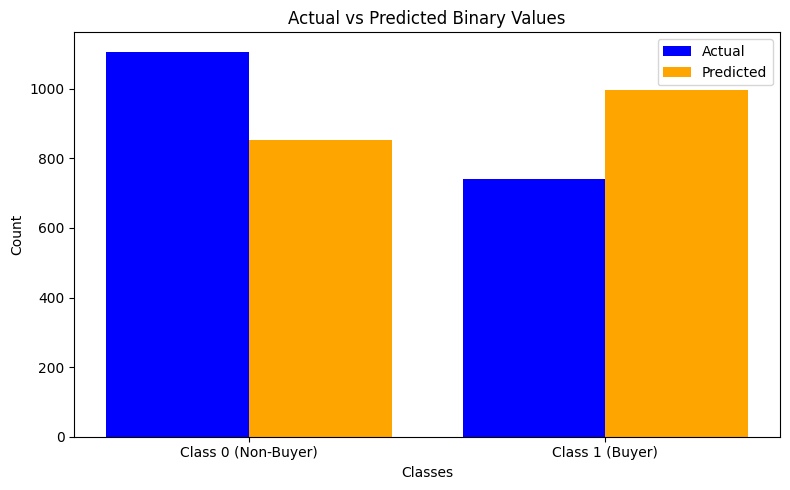

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Count occurrences for each class (0 and 1) in actual and predicted values
actual_counts = np.bincount(y_test)
predicted_counts = np.bincount(y_pred)

# Create a bar chart
labels = ['Class 0 (Non-Buyer)', 'Class 1 (Buyer)']
x = np.arange(len(labels))  # the label locations

plt.figure(figsize=(8, 5))
plt.bar(x - 0.2, actual_counts, width=0.4, label='Actual', color='blue')
plt.bar(x + 0.2, predicted_counts, width=0.4, label='Predicted', color='orange')

# Add labels and title
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Actual vs Predicted Binary Values')
plt.xticks(x, labels)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [21]:
import joblib

In [22]:
# Save the trained model
joblib.dump(best_xgb, 'xgb_model.pkl')  # Replace 'xgb_model.pkl' with your desired file name
print("Model saved successfully!")

Model saved successfully!
